In [435]:
from cv2 import cv2
import numpy as np
from matplotlib import pyplot as plt

In [436]:
# just  a function for printing images
def display_img(title, img):
    cv2.imshow(title, img)

#Only considering sharps for now
def getNextSharp(first_note):
    if first_note == "A#":
        return "C#"
    elif first_note == "C#":
        return "D#"
    elif first_note == "D#":
        return "F#"
    elif first_note == "F#":
        return "G#"
    elif first_note == "G#":
        return "A#"
    

#Flats
def getNextFlat(first_note):
    if first_note == "B♭":
        return "D♭"
    elif first_note == "D♭":
        return "E♭"
    elif first_note == "E♭":
        return "G♭"
    elif first_note == "G♭":
        return "A♭"
    elif first_note == "A♭":
        return "B♭"
      
#White notes
def getNextNote(first_note):
    if first_note == "A":
        return "B"
    elif first_note == "B":
        return "C"
    elif first_note == "C":
        return "D"
    elif first_note == "D":
        return "E"
    elif first_note == "E":
        return "F"
    elif first_note == "F":
        return "G"
    elif first_note == "G":
        return "A"


## 1. Load image in

Always start at the first frame - before ANY keys are clicked. This is because if a note is coloured on the keys themselves, our thresholding set-up doesn't work.

**There is an issue when people have intros...**

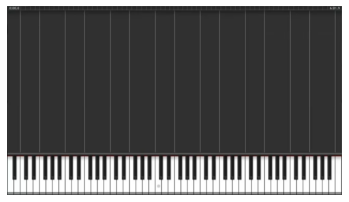

In [437]:
#sample piano image from youtube
img = cv2.imread("synthesia.png")

#converting to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

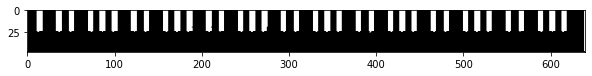

In [438]:
#Assume that the keys are definitely in the bottom half of the image
keys = img.copy()
keys = keys[keys.shape[0]//2:,:]

gray_keys = cv2.cvtColor(keys, cv2.COLOR_BGR2GRAY)

#edge detection 
std_dev = 0
k = 5
t1 = 200
t2 = 200

blurred = cv2.GaussianBlur(gray_keys, (k,k), std_dev)
edges = cv2.Canny(blurred, t1,t2, apertureSize = 3)

##########################################
### Using hough transform to identify lines 
lines = cv2.HoughLines(edges, 1, np.pi/180, 300)
#empty list - will be added with pixels that correspond with 
#the lines generated by hough transform 
y_cord = []


#iterating through lines
for line in lines: 
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    y_cord.append(y0) #appending to list
    x1 = int(x0 + 1500 * (-b))
    y1 = int(y0 + 1500 * (a))
    x2 = int(x0 - 1500 * (-b))
    y2 = int(y0 - 1500 * (a))
    cv2.line(keys, (x1,y1), (x2,y2), (0,255,0),2)

# ***We only want to crop by TWO coordinates - will need to figure this out 
# #sorting list and getting rid of smallest value
# y_cord.sort(reverse=True)
# y_cord.pop()

#cropping the image based on y_cord list
crop_img = keys[int(y_cord[1])+20:int(y_cord[0])]
crop_blur = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)

#Using standard threshold to create contrast between white/black keys
_, th1 = cv2.threshold(crop_blur, 85, 150, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,10))
plt.imshow(th1, cmap = "gray")
plt.show()

I count 36 black keys.


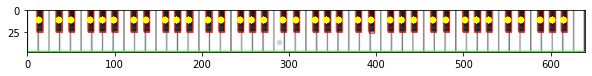

In [439]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 1
output = cv2.connectedComponentsWithStats(th1, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
# print(centroids.shape)

final_labels_bl = []

output = crop_img.copy()

#For loop only used for displaying 
for i in range(1, num_labels):
#     if i == 0:
#         text = "examining component {}/{} (background)".format(i + 1, num_labels)
#     else:
#         text = "examining component {}/{}".format(i+1, num_labels)

#     print("[INFO] {}".format(text))
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    if (100 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels_bl.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        cv2.circle(output, (int(cX), int(cY)), 4, (255,255,0), -1)
        componentMask = (labels == i).astype("uint8") * 255
        display_img("Output", output)
        display_img("Connected Component", componentMask)
        cv2.waitKey(0)

plt.figure(figsize=(10,10))
plt.imshow(output)
print("I count {} black keys.".format(len(final_labels_bl)))

# #just for visualization lol
# for i in range(len(final_labels)):
#     xc,yc = centroids[final_labels[i]]
#     #x1 = stats[final_labels[i], cv2.CC_STAT_LEFT]
#     #del_x = stats[final_labels[i], cv2.CC_STAT_WIDTH]
#     #lol = cv2.line(img,(int(x1),0),(int(x1),900),(0,255,0),1)
#     #lol = cv2.line(img,(int(x1+del_x),0),(int(x1+del_x),900),(0,255,0),1)
#     lol = cv2.line(img,(int(xc),0),(int(xc),900),(0,0,255),1)
#     cv2.imshow("lol", lol)
#     cv2.waitKey(0)
    
cv2.destroyAllWindows()

# 2. Label Black Keys
We don't need to do distance math anymore. If we detect 36 black keys, we know that the first black key is A#.

In [440]:
# #Printing out the difference between black keys
# #figure out someway to normalize this data so 
# #it works with all figures
# difference = []
# for i in range(len(final_labels)-1):
#     x2,y2 = centroids[final_labels[i+1]]
#     x1,y1 = centroids[final_labels[i]]
#     diff = x2-x1
#     difference.append(diff)
#     print(diff)

# #plotting distance between black keys vs centroids of all black keys
# x_axis = []
# for i in range(len(final_labels)-1):
#     x = centroids[final_labels[i]][0]
#     #print(x)
#     x_axis.append(x)

# plt.plot(x_axis, difference)
# plt.show()

In [441]:
# #checking the difference for the next three notes to figure out
# #which note is being played
# ##########
# #! JUST A PROTOTYPE - NEEDS TO BE WOKED ON
# #right now it's hardcoded with numbers (40,20).. but needs to be normalized
# #########
# first_note = None
# if (difference[0] > 20):
#     if (difference[1] > 20):
#         pass
#     else:
#         if (difference[2] > 20):
#             first_note = 'A#'
#             print(first_note)

# black_key_dict = {}
# for i in range(len(final_labels)):
#     x = centroids[final_labels[i]][0]
#     black_key_dict[x] = first_note
#     first_note = getNextNote(first_note)

# print(black_key_dict)

*final_labels* is the 36 integer indices that tell us if the returned centroids are black keys. 

For example, if centroids returns 39 possible connected components, final_label is the list of 36 indices that we consider are black keys.

In [442]:
# #Label indices starting from A#
# if len(final_labels_bl) == 36:
#     first_note = "A#"
#     black_key_dict = {}
#     for i in range(len(final_labels_bl)):
#         x = centroids[final_labels_bl[i]][0]
#         black_key_dict[x] = first_note
#         first_note = getNextSharp(first_note)
        
# tmp = img.copy()

# #Labeling all the black keys
# for centroid in black_key_dict:
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     y = tmp.shape[0]*3//4
#     lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
#     lol = cv2.putText(tmp, black_key_dict[centroid], (int(centroid), y), font, 0.5, (0,255,0), 1)
#     cv2.imshow("Label Sharps", tmp)
#     cv2.waitKey(0)
    
# cv2.destroyAllWindows()

In [443]:
#TESTING LIST
if len(final_labels_bl) == 36:
    first_note = "A#"
    black_key_list = []
    for i in range(len(final_labels_bl)):
        x = centroids[final_labels_bl[i]][0]
        black_key_list.append([x,first_note])
        first_note = getNextSharp(first_note)
        
sorted(black_key_list, key=lambda x: x[0])
tmp = img.copy()

#Labeling all the black keys
for (centroid, note) in black_key_list:
    font = cv2.FONT_HERSHEY_SIMPLEX
    y = tmp.shape[0]*3//4
    lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
    lol = cv2.putText(tmp, note, (int(centroid), y), font, 0.5, (0,255,0), 1)
    cv2.imshow("Label Sharps", tmp)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

# 2. Label White Keys
Testing white keys

In [444]:
# ##white key labelling
# #! NEED TO IMPLEMENT SPECIAL CONDITION FOR LAST WHITE KEYS 
# white_key_dict = {}
# for i in range(len(final_labels)-1):
#     x = centroids[final_labels[i]][0]

#     if (difference[i] > 40):
#         origin = x + difference[i]/2
#         delta_x = difference[i]/4
#         lol = cv2.line(img,(int(origin+delta_x),0), (int(origin+delta_x),900), (0,255,0),1)
#         lol = cv2.line(img,(int(origin-delta_x),0), (int(origin-delta_x),900), (0,255,0),1)
#         cv2.imshow("lol", lol)
#         cv2.waitKey(0)
#     else:
#         delta_x = difference[i]/2
#         lol = cv2.line(img,(int(x+delta_x),0), (int(x+delta_x),900), (0,255,0),1)
#         cv2.imshow("lol", lol)
#         cv2.waitKey(0)
        
# cv2.destroyAllWindows()

In [445]:
# #Using standard threshold to create contrast between white/black keys
# kernel = np.ones((24,1), np.uint8)
# _, th2 = cv2.threshold(crop_blur, 1, 5, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# d_im = cv2.dilate(th2, kernel, iterations=4)
# e_im = cv2.erode(d_im, kernel, iterations=4)

(53, 2)
I count 52 white keys.


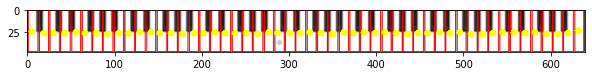

In [446]:
#Find optimal threshold - from testing we realized that the returned threshold is too low
import mahotas
k = 7
blurred = cv2.GaussianBlur(crop_blur, (k,k), 0)
T = mahotas.thresholding.otsu(blurred)*1.3

#We found the optimal threshold, now use it on our image
th2 = crop_blur.copy()  #Copy grayscale image and modify the copy
th2[th2>T] = 255     #Use Otsu's Threshold
th2[th2<T] = 0
# th2 = cv2.bitwise_not(th2) #Flips black-white



#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th2, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
print(centroids.shape)

final_labels_w = []

output = crop_img.copy()

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    
    if (100 < area < np.inf): #filtering out relavent detections (the ones big enough to be white keys)
        final_labels_w.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        cv2.circle(output, (int(cX), int(cY)), 4, (255,255,0), -1)
        componentMask = (labels == i).astype("uint8") * 255
#         display_img("Output", output)
#         display_img("Connected Component", componentMask)
#         cv2.waitKey(0)
        
# cv2.destroyAllWindows()
print("I count {} white keys.".format(len(final_labels_w)))

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()

In [447]:
# #Label indices starting from A#
# if len(final_labels_w) == 52:
#     first_note = "A"
#     white_key_dict = {}
#     for i in range(len(final_labels_w)):
#         x = centroids[final_labels_w[i]][0]
#         white_key_dict[x] = first_note
#         first_note = getNextNote(first_note)
        
# tmp = img.copy()

# #Labeling all the black keys
# for centroid in white_key_dict:
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     y = tmp.shape[0]*3//4
#     lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
#     lol = cv2.putText(tmp, white_key_dict[centroid], (int(centroid), y), font, 0.5, (0,255,0), 1)
#     cv2.imshow("Label Sharps", tmp)
#     cv2.waitKey(0)
    
# cv2.destroyAllWindows()

In [448]:
#TESTING LIST
if len(final_labels_w) == 52:
    first_note = "A"
    white_key_list = []
    for i in range(len(final_labels_w)):
        x = centroids[final_labels_w[i]][0]
        white_key_list.append([x,first_note])
        first_note = getNextNote(first_note)
        
sorted(white_key_list, key=lambda x: x[0])
tmp = img.copy()

#Labeling all the black keys
for (centroid, note) in white_key_list:
    font = cv2.FONT_HERSHEY_SIMPLEX
    y = tmp.shape[0]*3//4
    lol = cv2.line(tmp,(int(centroid),0),(int(centroid),900),(0,0,255),1)
    lol = cv2.putText(tmp, note, (int(centroid), y), font, 0.5, (0,255,0), 1)
    cv2.imshow("Label Notes", tmp)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

# 3. Assign Ranges
Order both the white and black keys together. 

For the range x:0 -> end, we assign a specify range to each key. For example, A: 0 - 10, A#: 10 - 15.

Our assumption is that the centroid of the key played will land in a discrete range with no overlap/ambiguity.

In [449]:
full_key_list = black_key_list + white_key_list
full_key_list = sorted(full_key_list, key=lambda x: x[0].astype(float))

full_key_list = np.array(full_key_list)

# full_key_list

In [450]:
test_list = np.empty([len(full_key_list), 2], dtype='object')
for i in range(0,len(full_key_list)):
    if i == 0:
        test_list[0,0] = '0'
        test_list[0,1] = full_key_list[i,1]
    else:
        test_list[i,0] = (full_key_list[i,0].astype(float)+full_key_list[i-1,0].astype(float))/2
        test_list[i,1] = full_key_list[i,1]


full_key_list = test_list

In [451]:
import bisect

def key_pressed(key_list, key_index):
    insertion_point = bisect.bisect_left(key_list[:,0].astype(float),key_index)
    
    if insertion_point >= len(key_list):
        insertion_point = len(key_list)-1
    print('You pressed the {} key.'.format(key_list[insertion_point,1]))

In [452]:
key_pressed(full_key_list, 500)

You pressed the G key.


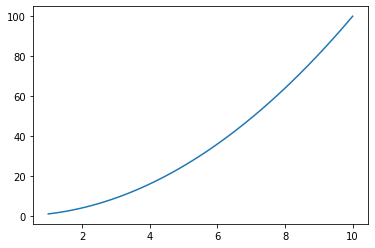

In [460]:
#Testing
x = np.linspace(1,10)
y = x**2

plt.plot(x,y)